In [1]:
import collections
import glob
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats

dataset_dir = "../DISAPERE/final_dataset/"

SUBSETS = "train dev test".split()

datasets = collections.defaultdict(list)

for subset in SUBSETS:
    for filename in glob.glob(dataset_dir + subset + "/*"):
        with open(filename, 'r') as f:
            datasets[subset].append(json.load(f))
            
all_pairs = sum(datasets.values(), [])

DPI = 300


FigText = collections.namedtuple("c", "x y text ha va rotation".split())
plt.rcParams.update({'font.size':'8',
                     'hatch.color': 'w'})

palette = sns.color_palette("Dark2")
OVERALL_IDX, EVAL_IDX, REQ_IDX, FACT_IDX,STRUCT_IDX, OTHER_IDX, SOCIAL_IDX, AUX_IDX = range(8)

for j in palette:
    print([i*255 for i in j])

[27.0, 158.0, 119.0]
[217.0, 95.0, 2.0]
[117.0, 112.0, 179.0]
[231.0, 41.0, 138.0]
[102.0, 166.0, 30.0]
[230.0, 171.0, 2.0]
[166.0, 118.0, 29.0]
[102.0, 102.0, 102.0]


# Figure 2: Spearman's rho between rebuttal sentence indices 

Median: 0.7942228154740686


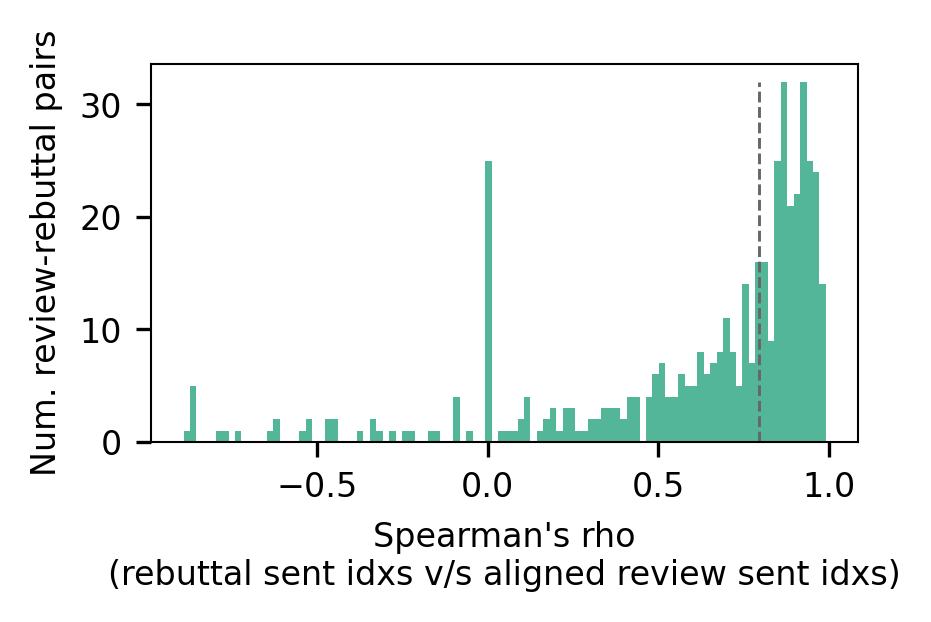

In [2]:
spearmen = []
for pair in all_pairs:
    alignment_list = []
    for sentence in pair["rebuttal_sentences"]:
        align_type, align_indices = sentence["alignment"]
        if align_type == "context_sentences":
            for review_index in align_indices:
                alignment_list.append([sentence["sentence_index"], review_index])
    if not alignment_list:
        continue
    a, b = zip(*alignment_list)
    if len(set(a)) == 1 or len(set(b)) == 1:
        continue
    spearmen.append(stats.spearmanr(*zip(*alignment_list)).correlation)    

median = np.median(spearmen)
print(f'Median: {median}')

fig, ax = plt.subplots(figsize=(3, 2), dpi=DPI)
fig = sns.histplot(spearmen, bins=100, color=palette[OVERALL_IDX], edgecolor='none')
ax.set_ylabel("Num. review-rebuttal pairs")
ax.set_xlabel("Spearman's rho\n(rebuttal sent idxs v/s aligned review sent idxs)")

plt.plot([median, median], [0, 32], linestyle="dashed", lw=0.7, color=palette[AUX_IDX])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

plt.tight_layout()

plt.savefig("figs/spearmen.pdf")

# Figure 3: Noncanonical responses

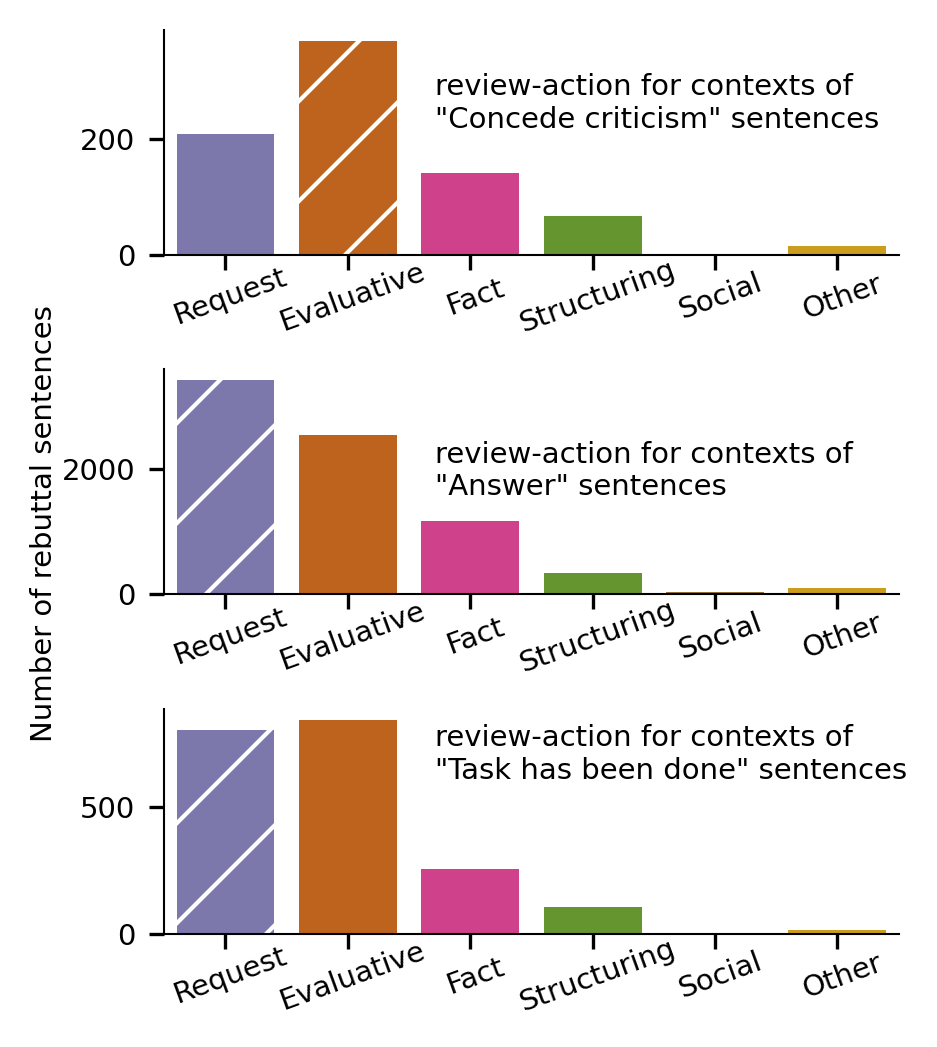

In [3]:

j = collections.defaultdict(lambda:collections.Counter())

for example in all_pairs:
    review_coarse_labels = [sentence["review_action"] for sentence in example["review_sentences"]]
    for rebuttal_sentence in example["rebuttal_sentences"]:
        fine = rebuttal_sentence["rebuttal_action"]
        align_type, aligned_idxs = rebuttal_sentence["alignment"]
        if align_type == "context_sentences":
            for aligned_idx in rebuttal_sentence["alignment"][1]:
                try:
                    j[fine][review_coarse_labels[aligned_idx]] += 1
                except IndexError:
                    pass

review_types = "arg_request arg_evaluative arg_fact arg_structuring arg_social arg_other".split()
colors = [palette[i] for i in [REQ_IDX, EVAL_IDX, FACT_IDX, STRUCT_IDX, SOCIAL_IDX, OTHER_IDX]]

type_name_map = {
    "arg_request": "Request",
    "arg_evaluative": "Evaluative",
    "arg_fact": "Fact",
    "arg_social": "Social",
    "arg_structuring": "Structuring",
    "arg_other": "Other",
}

full_eval_responses = [
    "rebuttal_accept-praise",
"rebuttal_concede-criticism",
"rebuttal_mitigate-criticism",
"rebuttal_reject-criticism",
]

full_request_responses = [
    "rebuttal_answer",
"rebuttal_by-cr",
"rebuttal_done",
"rebuttal_future",
"rebuttal_refute-question",
"rebuttal_reject-request",
]

eval_responses = [
"rebuttal_concede-criticism",
]

request_responses = [
    "rebuttal_answer",
"rebuttal_done",
]



plt.rcParams.update({'font.size':7})

fig, axes = plt.subplots(nrows=len(eval_responses + request_responses),
                         ncols=1, figsize=(3,3.5), dpi=DPI)

                     
ax_count = 0
for key in sorted(eval_responses) + sorted(request_responses):
    vals = j[key]
    bar = sns.barplot(x=[type_name_map[i] for i in review_types], y=[vals[i] for i in review_types],ax=axes[ax_count], palette=colors)
    
    if key in eval_responses:
        bar.patches[1].set_hatch("/")
    elif key in request_responses:
        bar.patches[0].set_hatch("/")
    else:
        assert False
    axes[ax_count].set_ylabel(key[9:])
    axes[ax_count].set_xticklabels(axes[ax_count].get_xticklabels(),rotation = 20,
                                  rotation_mode='anchor')
    ax_count += 1
    

for i in range(3):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].yaxis.label.set_visible(False)
    for axis in ['bottom','left']:
        axes[i].spines[axis].set_linewidth(0.5)

plot_labels = [
    FigText(0.45, 0.9, 'review-action for contexts of\n"Concede criticism" sentences', "left", "center", "horizontal"),
    FigText(0.45, 0.55, 'review-action for contexts of\n"Answer" sentences', "left", "center", "horizontal"),
    FigText(0.45, 0.28, 'review-action for contexts of\n"Task has been done" sentences', "left", "center", "horizontal"),
    FigText(0.0, 0.5, "Number of rebuttal sentences", "left", "center", "vertical")
]


for ft in plot_labels:
    fig.text(ft.x, ft.y, ft.text, ha=ft.ha, va=ft.va, rotation=ft.rotation)
    
plt.tight_layout()
plt.savefig("figs/noncanonical.pdf")



# Figure 4: Review action v/s rating

/var/folders/81/224zrp557vz1mk2khc5d7_8w0000gq/T/ipykernel_76972/2100865717.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels("0% 20% 40% 60% 80% 100%".split())


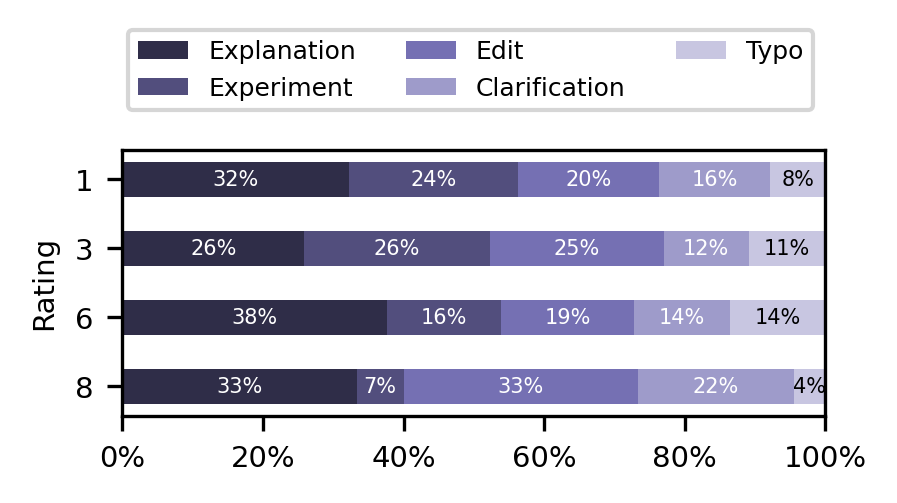

In [4]:
rating_action_counter = collections.defaultdict(lambda:collections.Counter())

blerp =set()
for example in all_pairs:
    if example["metadata"]["conference"] == "ICLR2019":
        continue
    rating = str(example["metadata"]["rating"])
    for sentence in example["review_sentences"]:
        if 'request' in sentence['fine_review_action']:
            rating_action_counter[rating][sentence["fine_review_action"]] += 1
            blerp.add(sentence["fine_review_action"])
            
#print(rating_action_counter)

#print(type_name_map)
#print("---")

review_types =['arg-request_explanation',
'arg-request_experiment',
 'arg-request_edit', 'arg-request_clarification',
'arg-request_typo', ]

type_name_map = {'arg-request_explanation': "Explanation",
'arg-request_experiment': "Experiment",
 'arg-request_edit': "Edit",
    'arg-request_clarification': "Clarification",
'arg-request_typo':"Typo",}

new_new_colors = [[47,45,72,255],
[82,78,125,255],
[117,112,179,255],
[158,155,202,255],
[200,198,225,255]]

final_colors = [[x/255 for x in c] for c in new_new_colors]

        
results = {}
for rating, label_counts in rating_action_counter.items():
    count_list = []
    normalizer = sum(label_counts.values()) - label_counts["none"]- label_counts["arg-request_result"]
    normalized_label_counts = {k:v/normalizer for k, v in label_counts.items()}
    
    for label in review_types:
        count_list.append(normalized_label_counts.get(label,0) * 100)
    results[rating] = count_list

category_names = [type_name_map[i] for i in review_types]

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = sorted(list(results.keys()))
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = final_colors
    fig, ax = plt.subplots(figsize=(3,2), dpi=300)
    ax.invert_yaxis()
    ax.set_ylabel("Rating")
    ax.set_xlim(0, np.sum(data, axis=1).max())
    ax.set_xticklabels("0% 20% 40% 60% 80% 100%".split())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.3 else 'black'
        if colname not in ["Social", "Other"]:
            ax.bar_label(rects, label_type='center', fmt="%.0f%%", color=text_color, fontsize=5)
    ax.legend(ncol=3, bbox_to_anchor=(1, 1.5),
              loc='upper right', fontsize=6)

    return fig, ax


survey(results, category_names)
plt.tight_layout()
plt.savefig('figs/action-rating.pdf')

# Figure 5: Agreeability

Needs attention:  28
Total:  159


,agg,rating
agg,1.000000,0.346783
rating,0.346783,1.000000


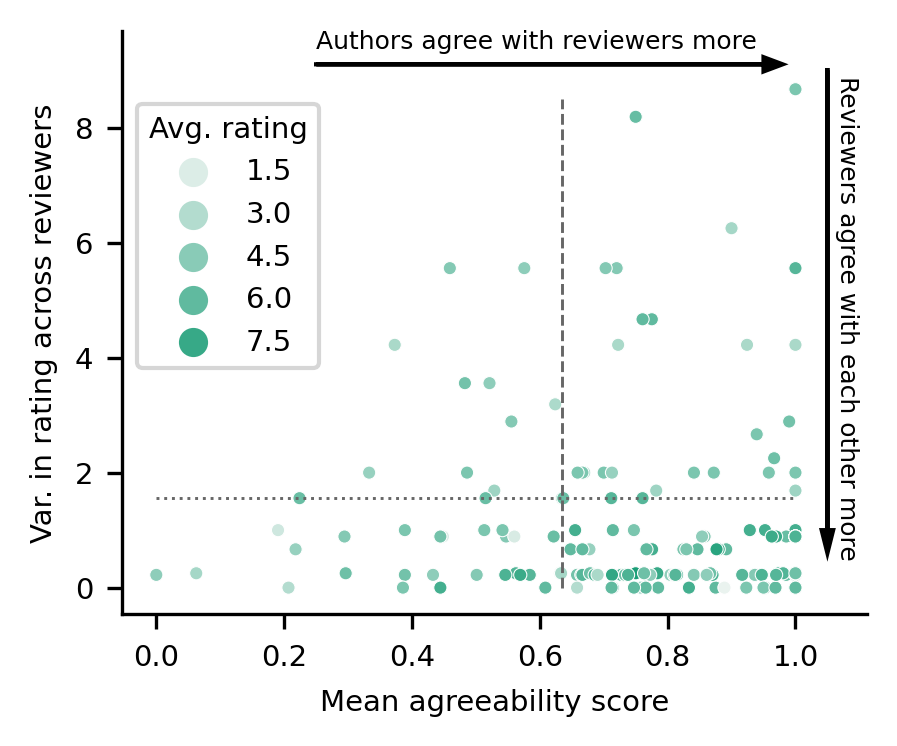

In [10]:
# Agreeability v/s variance

import numpy as np

def get_agreeability(pair_obj):
    coarse_counter = collections.Counter()
    for sentence in pair_obj["rebuttal_sentences"]:
        coarse_counter[sentence['rebuttal_stance']] += 1
    if 'concur' not in coarse_counter and 'dispute' not in coarse_counter:
        return {'agreeability': None}
    return {
      "agreeability":
        coarse_counter['concur'] / (coarse_counter['concur'] + coarse_counter['dispute'])
    }

# def draw_constant_line(value, other_axis_values, is_horizontal):
#     pass

forum_agreeability_map = collections.defaultdict(list)

ratings_counter = collections.Counter()

for pair in all_pairs:
    forum_agreeability_map[pair["metadata"]["forum_id"]].append((get_agreeability(pair)["agreeability"],pair["metadata"]["rating"] ))
    ratings_counter[(pair["metadata"]["conference"], pair["metadata"]["rating"])] += 1

agreeability_df_dicts = []


# Column names
agree_mean, rating_var, avg_rating = ["Mean agreeability score", "Var. in rating across reviewers", "Average rating"]
    
for forum, info in forum_agreeability_map.items():
    if len(info) == 1:
        continue
    agreeabilities, ratings = list(zip(*info))
    if None in agreeabilities:
        continue
    agreeability_df_dicts.append({
                                    "forum": forum,
                                    agree_mean: np.mean(agreeabilities),
                                 rating_var: np.var(ratings),
                                 avg_rating: np.mean(ratings)})
    
agreeability_df = pd.DataFrame.from_dict(agreeability_df_dicts)
agreeability_first_quartile = agreeability_df.quantile(0.25)[agree_mean]
variance_third_quartile = agreeability_df.quantile(0.75)[rating_var]

print("Needs attention: ", len([p for p in agreeability_df_dicts if (p[agree_mean] < agreeability_first_quartile and p[rating_var] < variance_third_quartile)]))
print("Total: ", len(agreeability_df_dicts))

plt.figure(figsize=(3,2.5), dpi=DPI)
ax = sns.scatterplot(
    data=agreeability_df,
    x=agree_mean,
    y=rating_var,
    hue=avg_rating, s=10,palette=sns.light_palette(palette[OVERALL_IDX], as_cmap=True))
plt.plot([agreeability_first_quartile,agreeability_first_quartile], [0,8.5], linestyle="dashed", lw=0.7, color=palette[AUX_IDX])
plt.plot([0,1], [variance_third_quartile,variance_third_quartile], linestyle="dotted",  lw=0.7, color=palette[AUX_IDX])


plot_labels = [
    FigText(0.25, 9.5, 'Authors agree with reviewers more', "left", "center", "horizontal"),
    FigText(1.1, 4.7, "Reviewers agree with each other more", "right", "center", 270)
]
plt.legend(
    bbox_to_anchor=(0,0.9),
    title="Avg. rating",
    title_fontsize=7,
    loc=2, fontsize=7)

ax.arrow(0.25, 9.1, 0.7,0, head_width=0.25, head_length=0.03, fc='k', ec='k')

ax.arrow(1.05, 9, 0, -8, head_width=0.018, head_length=0.4, fc='k', ec='k')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for ft in plot_labels:
    plt.text(ft.x, ft.y, ft.text, ha=ft.ha, va=ft.va, rotation=ft.rotation, fontdict={"size":6})
    

plt.tight_layout()
plt.savefig("figs/agreeability.pdf")

corr_df = pd.DataFrame.from_dict([{"agg":a, "rating":b} for a, b in sum(forum_agreeability_map.values(), [])])

corr_df.corr()

